# Numerical Optimization

This notebook uses the `Optim` package (https://github.com/JuliaNLSolvers/Optim.jl) which has general-purpose optimization routines.

As alternatives, consider the `NLopt` (https://github.com/JuliaOpt/NLopt.jl) or the `JuMP` (https://github.com/JuliaOpt/JuMP.jl) packages. They can easily handle various types of constrained optimization problems.

## Load Packages

In [1]:
using Optim, Dates

include("printmat.jl")

printmat2

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Optimization with One Choice Variable

Running 
```
Sol = optimize(x->fn1(x,0.5),x₀,x₁)
```
finds the `x` value (in the interval `[x₀,x₁]`) that *minimizes* `fn1(x,0.5)`. The solution should be $x=1.1)$.

The output (`Sol`) contains a lot of information. Print it to see, and extract the optimal `x` value as in the cell below.

If you 

In [3]:
function fn1(x,c)                    #notice: the function has two arguments
  value = 2*(x - 1.1)^2 - c
  return value
end  

fn1 (generic function with 1 method)

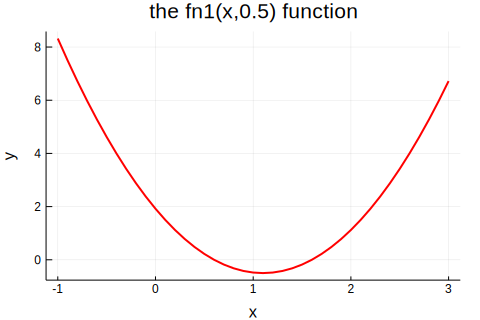

In [4]:
x = -1:0.1:3

p1 = plot(x,fn1.(x,0.5),color=:red,linewidth=2,legend=nothing)
title!("the fn1(x,0.5) function")
xlabel!("x")
ylabel!("y")

In [5]:
Sol = optimize(x->fn1(x,0.5),-2.0,3.0)            

printlnPs("The minimum is at: ", Optim.minimizer(Sol))     #the optimal x value
println("Compare with the plot above\n")   

println(Sol)

The minimum is at:      1.100
Compare with the plot above

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-2.000000, 3.000000]
 * Minimizer: 1.100000e+00
 * Minimum: -5.000000e-01
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6


## (extra) One Choice Variable: Supplying a Starting Guess Instead

If you prefer to give a starting guess `x₀` instead of an interval, then supply it as as vector `[x₀]`:
```
Sol = optimize(x->fn1(first(x),0.5),[x₀],LBFGS())  
```
Notice: *(a)* `first(x)` to make it a function of the first element in the vector; *(b)* choose the `LBFGS()` method since the default method does not work in the case of only one choice variable.

In [6]:
Solb = optimize(x->fn1(first(x),0.5),[0.1],LBFGS())          

printlnPs("The minimum is at: ", Optim.minimizer(Solb))

The minimum is at:      1.100


# Several Choice Variables: Unconstrained Optimization

In the example below, we want to choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. The solution should be $(x,y)=(2,-3/4)$.

In [7]:
function fn2(p)                  
    (x,y) = (p[1],p[2])          #unpack the choice variables and get nicer names
     L    = (x-2)^2 + (4*y+3)^2
    return L
end

fn2 (generic function with 1 method)

In [8]:
nx = 2*41
ny = 2*61
x = range(1,stop=5,length=nx)    
y = range(-1,stop=0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny                   
    loss2d[i,j] = fn2([x[i];y[j]])
end

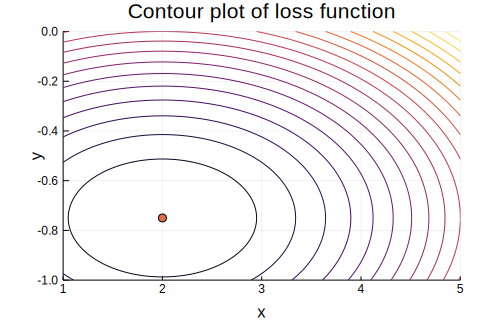

In [9]:
p1 = contour(x,y,loss2d',xlims=(1,5),ylims=(-1,0),legend=false,levels=21)  #notice: loss2d'
scatter!([2],[-0.75],label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

In [10]:
Sol = optimize(fn2,[0.0;0.0])        #use p->lossfn(p,other arguments) if 
                                     #there are additional (non-choice) arguments
printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Several Choice Variables: Bounds on the Solutions

The next few cells discuss two different ways of imposing bounds on the solution.

In the example below, we impose $2.75 \leq x$ (a lower bound) and $y \leq -0.3$ (an upper bound). We will see that only of these restrictions binds.

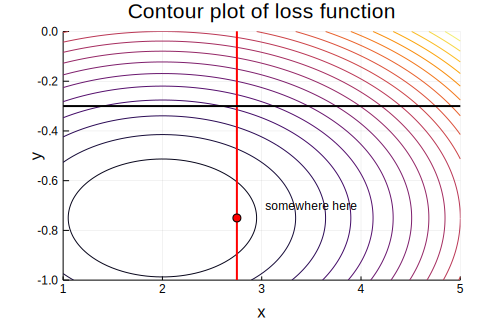

In [11]:
p1 = contour(x,y,loss2d',xlims=(1,5),ylims=(-1,0),legend=false,levels=21) 
plot!([2.75,2.75],[-1,0.5],color=:red,linewidth=2,label="2.75 < x")
plot!([1,5],[-0.3,-0.3],color=:black,linewidth=2,label="y < -0.3")
scatter!([2.75],[-0.75],color=:red,label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")
annotate!(3.5,-0.7,text("somewhere here",8))

In [12]:
lower = [2.75, -Inf]
upper = [Inf, -0.3]

Sol = optimize(fn2,lower,upper,[3.0,-0.5])   

printlnPs("The optimin is at (x,y)= ",Optim.minimizer(Sol))

The optimin is at (x,y)=      2.750    -0.750


# (extra) Several Choice Variables:  Supplying the Gradient

Supplying a function for calculating the derivatives improves speed and accuracy. See below for an example. (The inplace = false means that the function for the derivatives creates a new matrix at each call.)


In [13]:
function g2(x)                        #derivates of fn2 wrt. x[1] and x[2]
    G = [2*(x[1]-2), 2*4(4*x[2]+3)]   #creates a new vector: use inplace = false in optimize()
    return G
end
    
Sol3 = optimize(fn2,g2,[1.0,-0.5],inplace = false)
println(Sol3)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [1.0,-0.5]
 * Minimizer: [2.0000000000000004,-0.7500000000000007]
 * Minimum: 7.296963e-30
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 9.34e-01 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.20e+29 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.13e-14 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 7
 * Gradient Calls: 7
